In [3]:
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

In [4]:
workspace_path = "real-vs-fake-classification/"

test_set = workspace_path + 'test/'
train_set = workspace_path + 'train/'
valid_set = workspace_path + 'Validation/'

In [5]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
from torchvision import models
#veri setleri, dönüşümler ve önceden eğitilmiş modellerle çalışmak için kullanılıyor
#sinir ağları ve optimizasyon algoritmaları için kullanılıyor

In [6]:
#görüntüyü Tensor formatına dönüştürür
train_transforms = transforms.Compose([transforms.Resize((512,512)),        #512 değerini değiştirebiliriz. daha az yapmak daha hızlı olur
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomAutocontrast(0.3),
                                       transforms.RandomAffine(5),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

valid_transforms = transforms.Compose([transforms.Resize((512,512)),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize((512,512)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

In [7]:
#eğitim ve doğrulama verilerini yükleyip, dönüşümler uygulayarak ve veri yükleyiciler 
#oluşturarak modelin eğitim ve doğrulama süreçleri için hazır hale getirir
train_data = datasets.ImageFolder(train_set, transform=train_transforms)
valid_data = datasets.ImageFolder(valid_set, transform=valid_transforms)

train_load = torch.utils.data.DataLoader(train_data, batch_size=4, shuffle=True)#batch size değeri de değiştirilebilir
valid_load = torch.utils.data.DataLoader(valid_data, batch_size=4)

In [8]:
class_names = os.listdir(train_set)
train_images_count = {}
valid_images_count = {}
test_images_count = {}

for i in class_names:
    train_images_count[i] = len(os.listdir(os.path.join(train_set, i)))

for i in class_names:
    valid_images_count[i] = len(os.listdir(os.path.join(valid_set, i)))

print(f"TRAIN SET NUMBER: {train_images_count}")
print(f"VALIDATION SET NUMBER: {valid_images_count}")

TRAIN SET NUMBER: {'fake': 532, 'real': 665}
VALIDATION SET NUMBER: {'fake': 228, 'real': 284}


In [9]:
#modelin tahminlerini ve gerçek etiketleri gösteren bir dizi görüntüyü çizerek modelin performansını görselleştirmektir
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]
transforms.Normalize(mean=mean_nums, std=std_nums)
#resimleri normalize etmek için kullanılan ortalama ve standart sapma değerlerini içerir

Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

In [10]:
def imshow(inp, size=(40,40), title=None):
    inp = inp.numpy().transpose((1, 2, 0)) #kanal, yükseklik, genişlik
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1) #değerleri 0 ile 1 arasında sınırlar
    plt.figure(figsize=size)
    plt.imshow(inp)
    if title is not None:
        plt.title(title, size=30)
    plt.pause(0.001)

In [11]:
def visualize_model(model, testloader, device, class_names, num_images=9):
    #model: Tahmin yapacak olan derin öğrenme modeli
    #testloader: Test veri yükleyicisi (dataloader), modelin test edileceği veri kümesini sağlar
    #device: Modelin ve verinin çalıştırılacağı cihaz (CPU veya GPU)
    #class_names: Sınıf isimlerinin listesi, her sınıfa karşılık gelen adlar içerir
    #num_images: Görselleştirilecek toplam görüntü sayısı (varsayılan olarak 9)
    was_training = model.training
    model.eval()
    images_handled = 0
    fig = plt.figure(figsize=(20, 20))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(testloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):#batch boyutu
                images_handled += 1
                ax = plt.subplot(num_images, 2, images_handled)
                ax.axis('off')
                ax.set_title('Actual: {} Predicted: {}'.format(class_names[labels[j].item()], class_names[preds[j].item()]))
                imshow(inputs.cpu().data[j], (8, 8))

                if images_handled == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)
        #was_training: Modelin mevcut eğitim modunu kaydeder (eğitimde mi değil mi)

In [12]:
egitimler = workspace_path + 'egitimler/'

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

In [14]:
mobileNetV3Sonuc = egitimler + 'MobileNetV3/'

MobileNetV3 = models.mobilenet_v3_large(pretrained=True)
num_ftrs = MobileNetV3.classifier[3].in_features
MobileNetV3.classifier[3] = nn.Linear(num_ftrs, 2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MobileNetV3.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(MobileNetV3.parameters(), lr=0.001, momentum=0.9)

epochs = 10
best_accuracy = 0.0
for epoch in range(epochs):
    train_loss = 0.0
    valid_loss = 0.0
    accuracy = 0.0

    MobileNetV3.train()
    for data, target in train_load:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = MobileNetV3(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)

    MobileNetV3.eval()
    for data, target in valid_load:
        data, target = data.to(device), target.to(device)
        output = MobileNetV3(data)
        loss = criterion(output, target)
        valid_loss += loss.item() * data.size(0)

        prob = torch.exp(output)
        top_p, top_class = prob.topk(1, dim=1)
        equals = top_class == target.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor)).item() #doğruluk oranını hesaplama
        
    train_loss = train_loss / len(train_load.dataset)
    valid_loss = valid_loss / len(valid_load.dataset)
    accuracy = accuracy / len(valid_load)
    print(f'Epoch: {epoch+1} \tTraining Loss: {train_loss:.6f} \tValidation Loss: {valid_loss:.6f} \tValidation Accuracy: {accuracy*100:.2f}%')

    if accuracy >= best_accuracy:
        print('Saving model with validation accuracy: {:.2f}%'.format(accuracy * 100))
        best_accuracy = accuracy
        torch.save(MobileNetV3.state_dict(), "C:/Users/myusu/OneDrive/Masaüstü/cnn_proje/egitimler/MobileNetV3/best_mobilenetv3large_result.pth")

c:\Users\myusu\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\myusu\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 1 	Training Loss: 0.674655 	Validation Loss: 0.640491 	Validation Accuracy: 64.45%
Saving model with validation accuracy: 64.45%
Epoch: 2 	Training Loss: 0.615177 	Validation Loss: 0.634610 	Validation Accuracy: 66.41%
Saving model with validation accuracy: 66.41%
Epoch: 3 	Training Loss: 0.557571 	Validation Loss: 0.573808 	Validation Accuracy: 71.29%
Saving model with validation accuracy: 71.29%
Epoch: 4 	Training Loss: 0.500000 	Validation Loss: 0.571153 	Validation Accuracy: 71.68%
Saving model with validation accuracy: 71.68%
Epoch: 5 	Training Loss: 0.450664 	Validation Loss: 0.517541 	Validation Accuracy: 76.17%
Saving model with validation accuracy: 76.17%
Epoch: 6 	Training Loss: 0.427766 	Validation Loss: 0.558408 	Validation Accuracy: 75.20%
Epoch: 7 	Training Loss: 0.397648 	Validation Loss: 0.495359 	Validation Accuracy: 77.93%
Saving model with validation accuracy: 77.93%
Epoch: 8 	Training Loss: 0.316316 	Validation Loss: 0.619650 	Validation Accuracy: 75.98%
Epoc

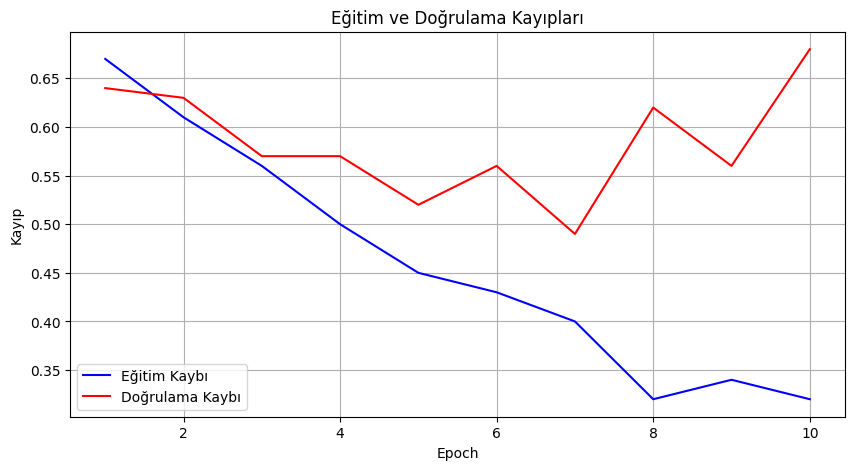

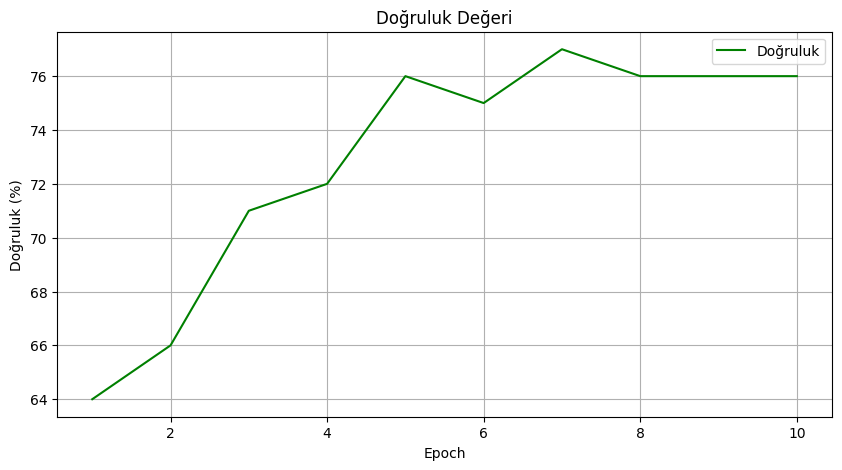

In [24]:
import matplotlib.pyplot as plt

train_losses = [0.67, 0.61, 0.56, 0.50, 0.45, 0.43, 0.40, 0.32, 0.34, 0.32] 
valid_losses = [0.64, 0.63, 0.57, 0.57, 0.52, 0.56, 0.49, 0.62, 0.56, 0.68]
accuracies = [64, 66, 71, 72, 76, 75, 77, 76, 76, 76]

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, 'b', label='Eğitim Kaybı')
plt.plot(epochs, valid_losses, 'r', label='Doğrulama Kaybı')
plt.title('Eğitim ve Doğrulama Kayıpları')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(epochs, accuracies, 'g', label='Doğruluk')
plt.title('Doğruluk Değeri')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk (%)')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
mobileNetV3smallSonuc = egitimler + 'MobileNetV3small/'

MobileNetV3small = models.mobilenet_v3_small(pretrained=True)
num_ftrs = MobileNetV3small.classifier[3].in_features
MobileNetV3small.classifier[3] = nn.Linear(num_ftrs, 2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MobileNetV3small.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(MobileNetV3small.parameters(), lr=0.001, momentum=0.9)

epochs = 10
best_accuracy = 0.0
for epoch in range(epochs):
    train_loss = 0.0
    valid_loss = 0.0
    accuracy = 0.0

    MobileNetV3small.train()
    for data, target in train_load:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = MobileNetV3small(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)

    MobileNetV3small.eval()
    for data, target in valid_load:
        data, target = data.to(device), target.to(device)
        output = MobileNetV3small(data)
        loss = criterion(output, target)
        valid_loss += loss.item() * data.size(0)

        prob = torch.exp(output)
        top_p, top_class = prob.topk(1, dim=1)
        equals = top_class == target.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        
    train_loss = train_loss / len(train_load.dataset)
    valid_loss = valid_loss / len(valid_load.dataset)
    accuracy = accuracy / len(valid_load)
    print(f'Epoch: {epoch+1} \tTraining Loss: {train_loss:.6f} \tValidation Loss: {valid_loss:.6f} \tValidation Accuracy: {accuracy*100:.2f}%')

    if accuracy >= best_accuracy:
        print('Saving model with validation accuracy: {:.2f}%'.format(accuracy * 100))
        best_accuracy = accuracy
        torch.save(MobileNetV3small.state_dict(), "C:/Users/myusu/OneDrive/Masaüstü/cnn_proje/egitimler/MobileNetV3small/best_mobilenetv3small_result.pth")

c:\Users\myusu\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to C:\Users\myusu/.cache\torch\hub\checkpoints\mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:06<00:00, 1.58MB/s]


Epoch: 1 	Training Loss: 0.683169 	Validation Loss: 0.648785 	Validation Accuracy: 63.09%
Saving model with validation accuracy: 63.09%
Epoch: 2 	Training Loss: 0.631749 	Validation Loss: 0.652126 	Validation Accuracy: 61.91%
Epoch: 3 	Training Loss: 0.598667 	Validation Loss: 0.626050 	Validation Accuracy: 65.62%
Saving model with validation accuracy: 65.62%
Epoch: 4 	Training Loss: 0.581200 	Validation Loss: 0.600951 	Validation Accuracy: 68.36%
Saving model with validation accuracy: 68.36%
Epoch: 5 	Training Loss: 0.529368 	Validation Loss: 0.648572 	Validation Accuracy: 66.02%
Epoch: 6 	Training Loss: 0.470579 	Validation Loss: 0.669685 	Validation Accuracy: 66.41%
Epoch: 7 	Training Loss: 0.479649 	Validation Loss: 0.581802 	Validation Accuracy: 73.63%
Saving model with validation accuracy: 73.63%
Epoch: 8 	Training Loss: 0.417806 	Validation Loss: 0.713161 	Validation Accuracy: 68.95%
Epoch: 9 	Training Loss: 0.398057 	Validation Loss: 0.657633 	Validation Accuracy: 69.92%
Epoch:

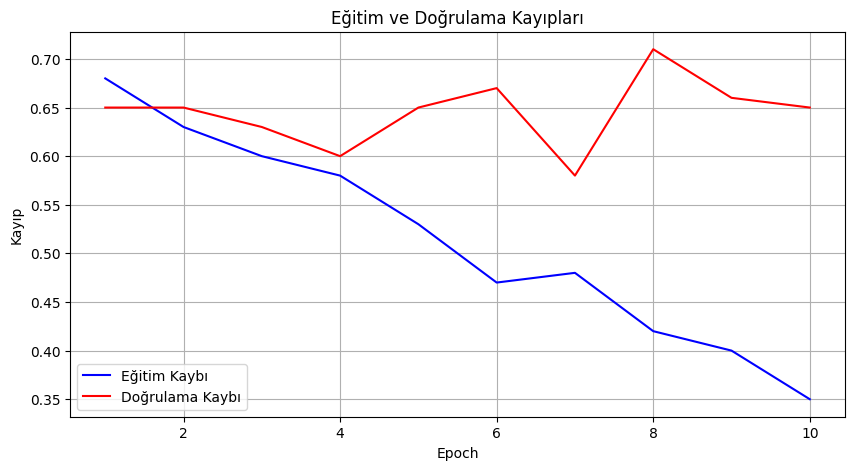

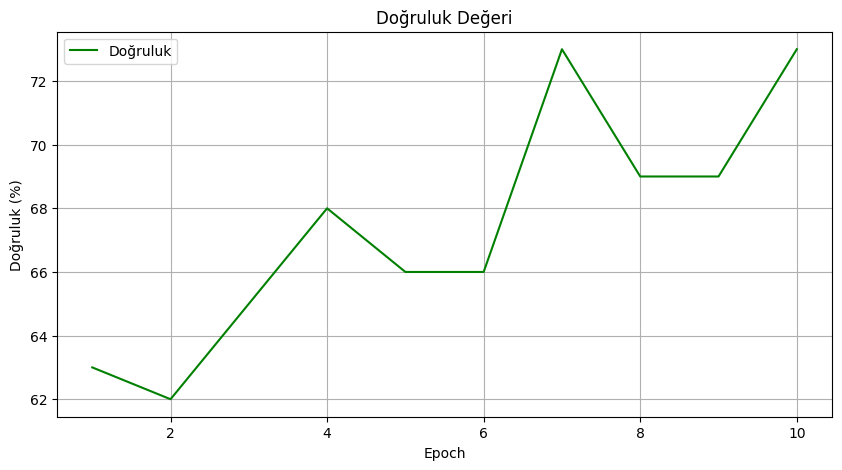

In [23]:
import matplotlib.pyplot as plt

train_losses = [0.68, 0.63, 0.60, 0.58, 0.53, 0.47, 0.48, 0.42, 0.40, 0.35] 
valid_losses = [0.65, 0.65, 0.63, 0.60, 0.65, 0.67, 0.58, 0.71, 0.66, 0.65]
accuracies = [63, 62, 65, 68, 66, 66, 73, 69, 69, 73]

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, 'b', label='Eğitim Kaybı')
plt.plot(epochs, valid_losses, 'r', label='Doğrulama Kaybı')
plt.title('Eğitim ve Doğrulama Kayıpları')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(epochs, accuracies, 'g', label='Doğruluk')
plt.title('Doğruluk Değeri')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk (%)')
plt.legend()
plt.grid(True)
plt.show()

In [25]:
shuffleNetSonuc = egitimler + 'ShuffleNet/'

ShuffleNet = models.shufflenet_v2_x1_0(pretrained=True)
num_ftrs = ShuffleNet.fc.in_features
ShuffleNet.fc = nn.Linear(num_ftrs, 2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ShuffleNet.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(ShuffleNet.parameters(), lr=0.01, momentum=0.9) #bütün başarı değerleri aynı çıktığı için 'learning rate' değiştim

epochs = 10
best_accuracy = 0.0
for epoch in range(epochs):
    train_loss = 0.0
    valid_loss = 0.0
    accuracy = 0.0

    ShuffleNet.train()
    for data, target in train_load:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = ShuffleNet(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)

    ShuffleNet.eval()
    for data, target in valid_load:
        data, target = data.to(device), target.to(device)
        output = ShuffleNet(data)
        loss = criterion(output, target)
        valid_loss += loss.item() * data.size(0)

        prob = torch.exp(output)
        top_p, top_class = prob.topk(1, dim=1)
        equals = top_class == target.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        
    train_loss = train_loss / len(train_load.dataset)
    valid_loss = valid_loss / len(valid_load.dataset)
    accuracy = accuracy / len(valid_load)
    print(f'Epoch: {epoch+1} \tTraining Loss: {train_loss:.6f} \tValidation Loss: {valid_loss:.6f} \tValidation Accuracy: {accuracy*100:.2f}%')

    if accuracy >= best_accuracy:
        print('Saving model with validation accuracy: {:.2f}%'.format(accuracy * 100))
        best_accuracy = accuracy
        torch.save(ShuffleNet.state_dict(), "C:/Users/myusu/OneDrive/Masaüstü/cnn_proje/egitimler/ShuffleNet/best_shufflenet_result.pth")

c:\Users\myusu\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\myusu\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1`. You can also use `weights=ShuffleNet_V2_X1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 1 	Training Loss: 0.691044 	Validation Loss: 0.687843 	Validation Accuracy: 55.66%
Saving model with validation accuracy: 55.66%
Epoch: 2 	Training Loss: 0.686940 	Validation Loss: 0.678293 	Validation Accuracy: 62.30%
Saving model with validation accuracy: 62.30%
Epoch: 3 	Training Loss: 0.669133 	Validation Loss: 0.650388 	Validation Accuracy: 57.81%
Epoch: 4 	Training Loss: 0.645418 	Validation Loss: 0.629042 	Validation Accuracy: 66.80%
Saving model with validation accuracy: 66.80%
Epoch: 5 	Training Loss: 0.625231 	Validation Loss: 0.668243 	Validation Accuracy: 62.70%
Epoch: 6 	Training Loss: 0.600660 	Validation Loss: 0.641876 	Validation Accuracy: 67.19%
Saving model with validation accuracy: 67.19%
Epoch: 7 	Training Loss: 0.604964 	Validation Loss: 0.687436 	Validation Accuracy: 57.42%
Epoch: 8 	Training Loss: 0.565685 	Validation Loss: 0.688390 	Validation Accuracy: 63.87%
Epoch: 9 	Training Loss: 0.570017 	Validation Loss: 0.662202 	Validation Accuracy: 65.23%
Epoch:

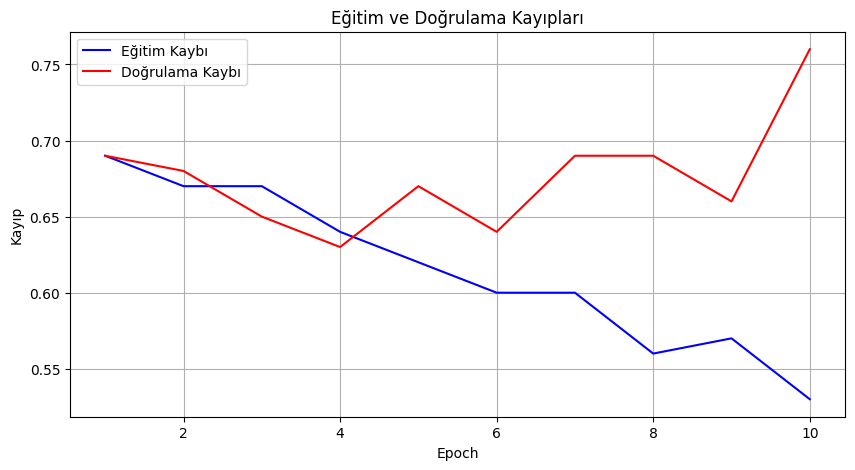

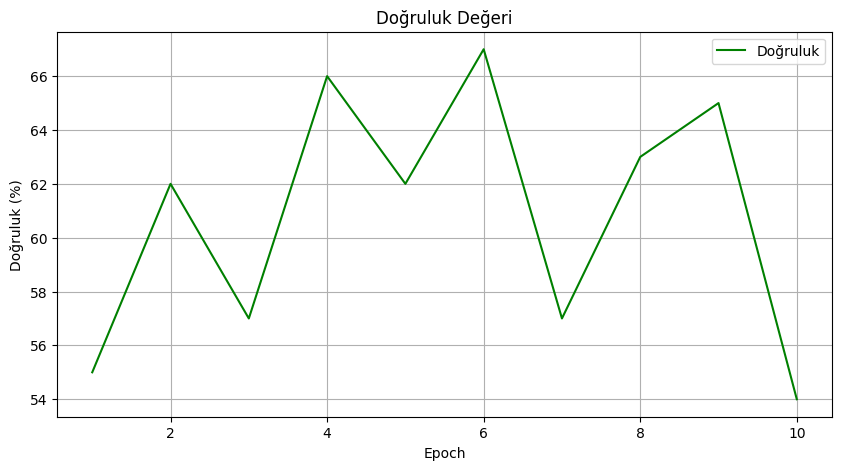

In [26]:
import matplotlib.pyplot as plt

train_losses = [0.69, 0.67, 0.67, 0.64, 0.62, 0.60, 0.60, 0.56, 0.57, 0.53] 
valid_losses = [0.69, 0.68, 0.65, 0.63, 0.67, 0.64, 0.69, 0.69, 0.66, 0.76]
accuracies = [55, 62, 57, 66, 62, 67, 57, 63, 65, 54]

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, 'b', label='Eğitim Kaybı')
plt.plot(epochs, valid_losses, 'r', label='Doğrulama Kaybı')
plt.title('Eğitim ve Doğrulama Kayıpları')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(epochs, accuracies, 'g', label='Doğruluk')
plt.title('Doğruluk Değeri')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk (%)')
plt.legend()
plt.grid(True)
plt.show()

In [21]:
SqueezeNetSonuc = egitimler + 'SqueezeNet/'

SqueezeNet = models.squeezenet1_0(pretrained=True)
SqueezeNet.classifier[1] = nn.Conv2d(512, 2, kernel_size=(1, 1), stride=(1, 1))
SqueezeNet.num_classes = 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SqueezeNet.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(SqueezeNet.parameters(), lr=0.001, momentum=0.9)

epochs = 10
best_accuracy = 0.0
for epoch in range(epochs):
    train_loss = 0.0
    valid_loss = 0.0
    accuracy = 0.0

    SqueezeNet.train()
    for data, target in train_load:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = SqueezeNet(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)

    SqueezeNet.eval()
    for data, target in valid_load:
        data, target = data.to(device), target.to(device)
        output = SqueezeNet(data)
        loss = criterion(output, target)
        valid_loss += loss.item() * data.size(0)

        prob = torch.exp(output)
        top_p, top_class = prob.topk(1, dim=1)
        equals = top_class == target.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        
    train_loss = train_loss / len(train_load.dataset)
    valid_loss = valid_loss / len(valid_load.dataset)
    accuracy = accuracy / len(valid_load)
    print(f'Epoch: {epoch+1} \tTraining Loss: {train_loss:.6f} \tValidation Loss: {valid_loss:.6f} \tValidation Accuracy: {accuracy*100:.2f}%')

    if accuracy >= best_accuracy:
        print('Saving model with validation accuracy: {:.2f}%'.format(accuracy * 100))
        best_accuracy = accuracy
        torch.save(SqueezeNet.state_dict(), "C:/Users/myusu/OneDrive/Masaüstü/cnn_proje/egitimler/SqueezeNet/best_squeezenet_result.pth")

c:\Users\myusu\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_0_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/squeezenet1_0-b66bff10.pth" to C:\Users\myusu/.cache\torch\hub\checkpoints\squeezenet1_0-b66bff10.pth
100%|██████████| 4.78M/4.78M [00:01<00:00, 3.82MB/s]


Epoch: 1 	Training Loss: 0.694182 	Validation Loss: 0.686805 	Validation Accuracy: 60.16%
Saving model with validation accuracy: 60.16%
Epoch: 2 	Training Loss: 0.684239 	Validation Loss: 0.676888 	Validation Accuracy: 58.79%
Epoch: 3 	Training Loss: 0.673760 	Validation Loss: 0.658877 	Validation Accuracy: 62.30%
Saving model with validation accuracy: 62.30%
Epoch: 4 	Training Loss: 0.667645 	Validation Loss: 0.667397 	Validation Accuracy: 61.91%
Epoch: 5 	Training Loss: 0.657509 	Validation Loss: 0.671221 	Validation Accuracy: 60.55%
Epoch: 6 	Training Loss: 0.650080 	Validation Loss: 0.685488 	Validation Accuracy: 56.05%
Epoch: 7 	Training Loss: 0.632812 	Validation Loss: 0.640389 	Validation Accuracy: 61.33%
Epoch: 8 	Training Loss: 0.639407 	Validation Loss: 0.636121 	Validation Accuracy: 66.21%
Saving model with validation accuracy: 66.21%
Epoch: 9 	Training Loss: 0.610872 	Validation Loss: 0.620445 	Validation Accuracy: 66.41%
Saving model with validation accuracy: 66.41%
Epoch:

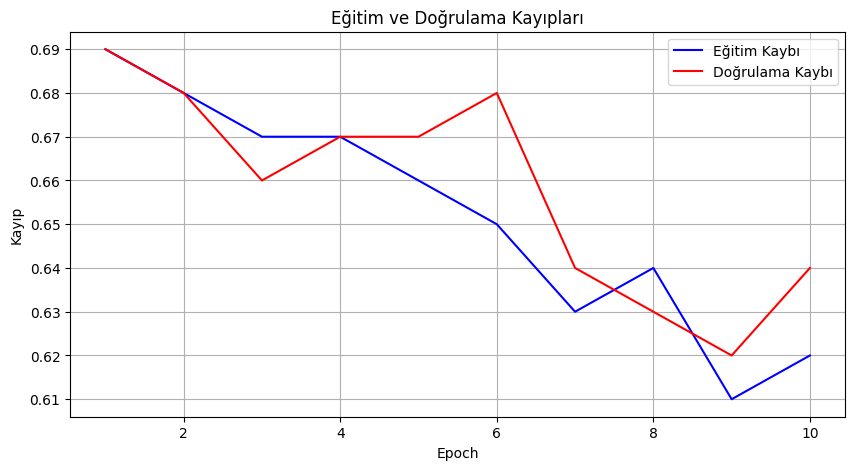

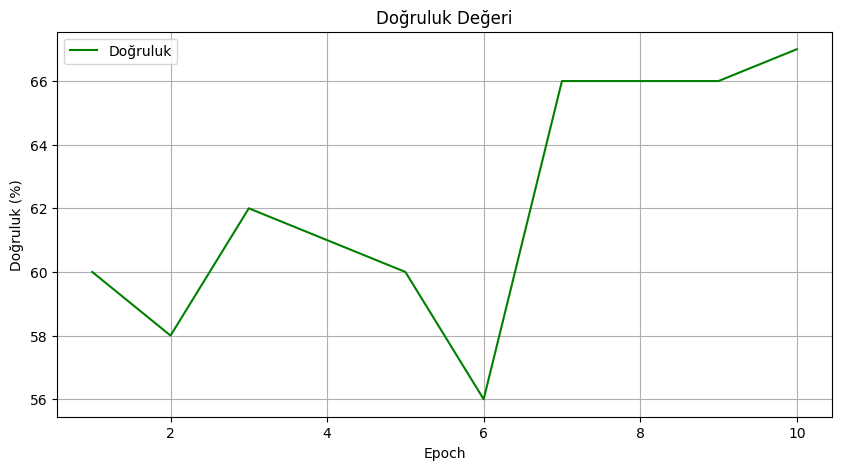

In [22]:
import matplotlib.pyplot as plt

train_losses = [0.69, 0.68, 0.67, 0.67, 0.66, 0.65, 0.63, 0.64, 0.61, 0.62] 
valid_losses = [0.69, 0.68, 0.66, 0.67, 0.67, 0.68, 0.64, 0.63, 0.62, 0.64]
accuracies = [60, 58, 62, 61, 60, 56, 66, 66, 66, 67]

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, 'b', label='Eğitim Kaybı')
plt.plot(epochs, valid_losses, 'r', label='Doğrulama Kaybı')
plt.title('Eğitim ve Doğrulama Kayıpları')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(epochs, accuracies, 'g', label='Doğruluk')
plt.title('Doğruluk Değeri')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk (%)')
plt.legend()
plt.grid(True)
plt.show()